# Internet availability prediction for Brazilian schools - initial models

This notebook presents two initial models for predicting internet availability in Brazilian schools. The first model uses a simple nearest-neighbors approach, while the second one builds a decision tree with several variables, including the presence and number of IT job openings nearby (in a 50km radius of the school).

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
from src.model_functions import prepare_data, get_cv_folds

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

## Input Data

The input data file contains information from Brazilian schools obtained via Unicef's GIGA project, as well as a summarization of Jobzi's proprietary information on job openings in Brazil.

In [2]:
# replace this with the folder and file name where the input data can be found
folder = '../data'
input_name = 'input_data.csv'

input_data = pd.read_csv(f'{folder}/{input_name}')

## A first model: nearest neighbors

A simple k-nearest neighbors model based solely on location (using the schools' latitude and longitude) achieves an ~82% accuracy on validation data for predicting if a school in Brazil is connected to the Internet.

In [3]:
X_train, y_train = prepare_data(input_data, for_train=True)
cv_folds = get_cv_folds(X_train, y_train)

In [4]:
knn = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': np.arange(1,13,2)}

clf_knn = GridSearchCV(estimator=knn,
                       param_grid=knn_param_grid,
                       cv=cv_folds,
                       verbose=1,
                       scoring=['accuracy', 'precision_weighted',
                                'recall_weighted', 'f1_weighted'],
                       refit='accuracy')

# model uses only latitude and longitude of schools as variables
clf_knn.fit(X_train[['latitude', 'longitude']], y_train)
print(clf_knn.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.8230462668913165


## A first improvement: decision tree

A more sophisticated decision tree model, using all variables from `input_data` (including data on the number and existence of job openings near the schools), achieves an ~86% accuracy on the validation data. 

In [5]:
tree = DecisionTreeClassifier()
tree_param_grid = {'max_depth': [1,2,4,8,16,32]}

clf_tree = GridSearchCV(estimator=tree,
                       param_grid=tree_param_grid,
                       cv=cv_folds,
                       verbose=1,
                       scoring=['accuracy', 'precision_weighted',
                                'recall_weighted', 'f1_weighted'],
                       refit='accuracy')

# model uses all available variables
clf_tree.fit(X_train, y_train)
print(clf_tree.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.8559787065426928


### Comparing the results

Below we compare the accuracy results for all models tested across the same 10 validation sets. We can see that the best model is a decision tree with a maximum depth of 8.

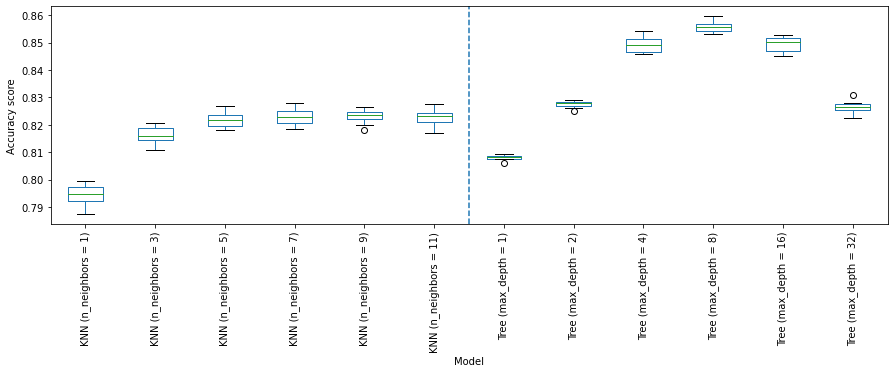

In [6]:
tree_results = pd.DataFrame(clf_tree.cv_results_, 
                            index=tree_param_grid['max_depth'])
tree_results.index = 'Tree (max_depth = ' + tree_results.index.astype(str) + ')'

knn_results = pd.DataFrame(clf_knn.cv_results_, 
                           index=knn_param_grid['n_neighbors'])
knn_results.index = 'KNN (n_neighbors = ' + knn_results.index.astype(str) + ')'

acc_cols = [col for col in tree_results.columns 
            if ('split' in col) and ('_accuracy' in col)]

fig, ax = plt.subplots(figsize=[15,4])
pd.concat([knn_results[acc_cols], 
           tree_results[acc_cols]]).T.plot(kind='box', ax=ax)
plt.xticks(rotation=90);
ax.axvline(6.5, linestyle='--');
plt.ylabel('Accuracy score')
plt.xlabel('Model');

## Predicting results for all schools

Below we predict the internet availability status of all schools in our dataset, including the ~36k schools for which there was no information regarding internet availability.

In [7]:
X, _ = prepare_data(input_data, for_train=False)
input_data['internet_availability_prediction'] = clf_tree.best_estimator_.predict(X).astype(bool)

In [8]:
# change here the location and name of the output file with predictions
output_folder = '../../../frontend/src/assets'
output_name = 'schools_dataset.csv'

cols_to_output = ['school_name', 
                  'latitude', 
                  'longitude', 
                  'dq_score', 
                  'student_count',
                  'school_type', 
                  'school_region', 
                  'internet_availability',
                  'internet_speed_Mbps', 
                  'city',
                  'state',
                  'municipality', 
                  'region',
                  'state_district', 
                  'postcode',
                  'it_jobs_below_50_km', 
                  'has_jobs_below_50_km',
                  'internet_availability_prediction']

input_data[cols_to_output].to_csv(f'{output_folder}/{output_name}', index=False)